In [62]:
#Importing the necessary libraries
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import warnings
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\RAM
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Loading the json data and converting it to a dataframe
with open("complaints-2021-05-14_08_16.json", 'r') as f: 
    data = json.load(f)
    df=pd.json_normalize(data)

In [3]:
#Data preparation
# Inspect the dataframe to understand the given data.
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_colwidth', 100)  

df.head()


_index      _type      _id  _score   _source.tags _source.zip_code _source.complaint_id                       _source.issue      _source.date_received _source.state _source.consumer_disputed              _source.product _source.company_response       _source.company _source.submitted_via _source.date_sent_to_company _source.company_public_response                         _source.sub_product _source.timely                                                                      _source.complaint_what_happened                                 _source.sub_issue _source.consumer_consent_provided
0  complaint-public-v2  complaint  3211475     0.0           None            90301              3211475   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00            CA                       N/A              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.                   Web    2019-04-13T12:00:00-05:00                            None                            Credit card debt            Yes                                                                                                                                      Debt is not yours              Consent not provided
1  complaint-public-v2  complaint  3229299     0.0  Servicemember            319XX              3229299     Written notification about debt  2019-05-01T12:00:00-05:00            GA                       N/A              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.                   Web    2019-05-01T12:00:00-05:00                            None                            Credit card debt            Yes  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...  Didn't receive enough information to verify debt                  Consent provided
2  complaint-public-v2  complaint  3199379     0.0           None            77069              3199379  Other features, terms, or problems  2019-04-02T12:00:00-05:00            TX                       N/A  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.                   Web    2019-04-02T12:00:00-05:00                            None  General-purpose credit card or charge card            Yes  I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...             Problem with rewards from credit card                  Consent provided
3  complaint-public-v2  complaint  2673060     0.0           None            48066              2673060      Trouble during payment process  2017-09-13T12:00:00-05:00            MI                       N/A                     Mortgage  Closed with explanation  JPMORGAN CHASE & CO.                   Web    2017-09-14T12:00:00-05:00                            None                  Conventional home mortgage            Yes                                                                                                                                                   None              Consent not provided
4  complaint-public-v2  complaint  3203545     0.0           None            10473              3203545                    Fees or interest  2019-04-05T12:00:00-05:00            NY                       N/A  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.              Referral    2019-04-05T12:00:00-05:00                            None  General-purpose credit card or charge card            Yes                                                                                                                              Charged too much interest                               N/A

In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided'], dtype='object')

In [5]:
#Assign new column names
df.rename(columns={
    '_index': 'index',
    '_type': 'type',
    '_id': 'id',
    '_score': 'score',
    '_source.tags': 'tags',
    '_source.zip_code': 'zip_code',
    '_source.complaint_id': 'complaint_id',
    '_source.issue': 'issue',
    '_source.date_received': 'date_received',
    '_source.state': 'state',
    '_source.consumer_disputed': 'consumer_disputed',
    '_source.product': 'product',
    '_source.company_response': 'company_response',
    '_source.company': 'company',
    '_source.submitted_via': 'submitted_via',
    '_source.date_sent_to_company': 'date_sent_to_company',
    '_source.company_public_response': 'company_public_response',
    '_source.sub_product': 'sub_product',
    '_source.timely': 'timely',
    '_source.complaint_what_happened': 'complaints',
    '_source.sub_issue': 'sub_issue',
    '_source.consumer_consent_provided': 'consumer_consent_provided'
}, inplace=True)

# Display the updated DataFrame
df.head()


index       type       id  score           tags zip_code complaint_id                               issue              date_received state consumer_disputed                      product         company_response               company submitted_via       date_sent_to_company company_public_response                                 sub_product timely                                                                                           complaints                                         sub_issue consumer_consent_provided
0  complaint-public-v2  complaint  3211475    0.0           None    90301      3211475   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00    CA               N/A              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.           Web  2019-04-13T12:00:00-05:00                    None                            Credit card debt    Yes                                                                                                                                      Debt is not yours      Consent not provided
1  complaint-public-v2  complaint  3229299    0.0  Servicemember    319XX      3229299     Written notification about debt  2019-05-01T12:00:00-05:00    GA               N/A              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.           Web  2019-05-01T12:00:00-05:00                    None                            Credit card debt    Yes  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...  Didn't receive enough information to verify debt          Consent provided
2  complaint-public-v2  complaint  3199379    0.0           None    77069      3199379  Other features, terms, or problems  2019-04-02T12:00:00-05:00    TX               N/A  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.           Web  2019-04-02T12:00:00-05:00                    None  General-purpose credit card or charge card    Yes  I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...             Problem with rewards from credit card          Consent provided
3  complaint-public-v2  complaint  2673060    0.0           None    48066      2673060      Trouble during payment process  2017-09-13T12:00:00-05:00    MI               N/A                     Mortgage  Closed with explanation  JPMORGAN CHASE & CO.           Web  2017-09-14T12:00:00-05:00                    None                  Conventional home mortgage    Yes                                                                                                                                                   None      Consent not provided
4  complaint-public-v2  complaint  3203545    0.0           None    10473      3203545                    Fees or interest  2019-04-05T12:00:00-05:00    NY               N/A  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.      Referral  2019-04-05T12:00:00-05:00                    None  General-purpose credit card or charge card    Yes                                                                                                                              Charged too much interest                       N/A

In [6]:
#Assign nan in place of blanks in the complaints column
df['complaints'].replace('', np.nan, inplace=True)
df['complaints'].head()

0                                                                                                    NaN
1    Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...
3                                                                                                    NaN
4                                                                                                    NaN
Name: complaints, dtype: object

In [7]:
df.shape

(78313, 22)

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints'], inplace=True)
df.shape

(21072, 22)

In [9]:
#Prepare the text for topic modeling
#Make the text lowercase
df['complaints'] = df['complaints'].str.lower()

In [10]:
#Remove text in square brackets
df['complaints'] = df['complaints'].str.replace(r'\[.*?\]', '', regex=True)

In [11]:
#Remove punctuation
df['complaints'] = df['complaints'].str.replace(f'[{string.punctuation}]', '', regex=True)


In [12]:
#Remove words containing numbers
df['complaints'] = df['complaints'].str.replace(r'\w*\d\w*', '', regex=True)
# Remove any extra spaces created by removing the words
df['complaints'] = df['complaints'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [13]:
df['complaints'].head()

1     good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...
2     i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary dat...
10    chase card was reported on however fraudulent application have been submitted my identity withou...
11    on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ...
14    my grand son give me check for i deposit it into my chase account after fund clear my chase bank...
Name: complaints, dtype: object

In [14]:
#function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['complaints_lemmatized'] = df['complaints'].apply(lemmatize_text)
df_clean = df[['complaints', 'complaints_lemmatized']]

In [16]:
#Sample df_clean
df_clean.head()

complaints                                                                                complaints_lemmatized
1   good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...  good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...
2   i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary dat...  I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date w...
10  chase card was reported on however fraudulent application have been submitted my identity withou...  chase card be report on however fraudulent application have be submit my identity without my con...
11  on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ...  on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticke...
14  my grand son give me check for i deposit it into my chase account after fund clear my chase bank...  my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...

In [17]:
df_clean.shape


(21072, 2)

In [18]:
#function to extract the POS tags 
def extract_filter_pos_tags(text):
    doc = nlp(text)
    filtered_text_pos = ' '.join([token.lemma_ for token in doc if token.pos_ == 'NOUN'])
    return filtered_text_pos

In [19]:
#Adding only nouns to the dataframe
df_clean['complaint_POS_removed'] = df_clean['complaints'].apply(extract_filter_pos_tags)

In [20]:
#Final df_clean sample
df_clean.head()

complaints                                                                                complaints_lemmatized                                                                                complaint_POS_removed
1   good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...  good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...  morning name stop bank cardmember service debt verification statement bank debt mail month debt ...
2   i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary dat...  I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date w...  xxxx agent anniversary date agent information order account anniversary date consent recording a...
10  chase card was reported on however fraudulent application have been submitted my identity withou...  chase card be report on however fraudulent application have be submit my identity without my con...                                  card application identity consent service credit identity applicant
11  on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ...  on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticke...  xxxx ticket offer ticket reward card information offer minute screen decision bank chase bank no...
14  my grand son give me check for i deposit it into my chase account after fund clear my chase bank...  my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...  son chase account fund chase bank account money son check money chase bank money son time check ...

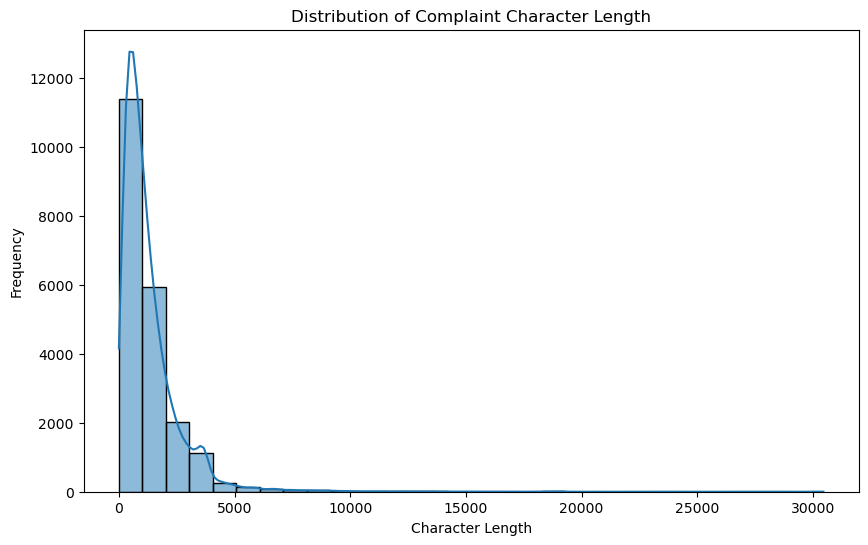

In [21]:
#Exploratory data analysis to get familiar with the data
#visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaints'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=30, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

In [22]:
df_clean.shape


(21072, 4)

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_text = ' '.join(df_clean['complaints'])

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_text.split() if word not in stop_words]



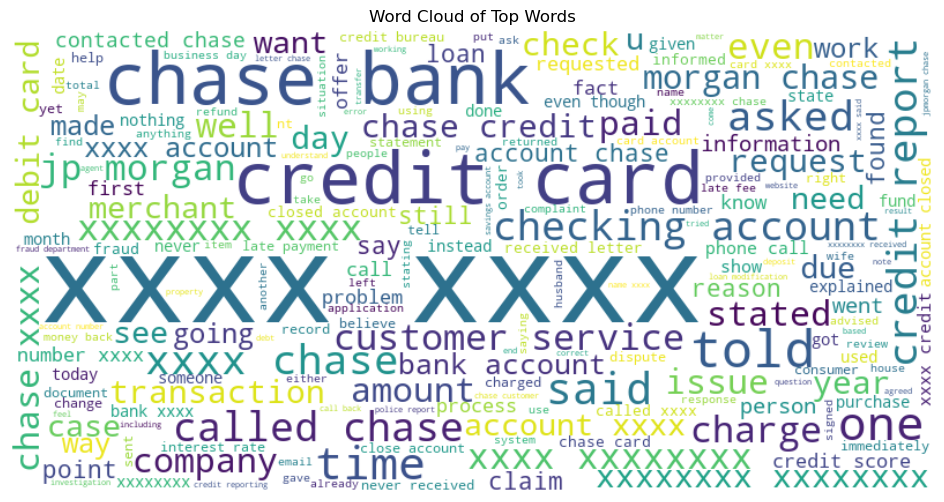

Top 40 words by frequency:
xxxx: 192541
chase: 79844
account: 42584
credit: 32671
xxxxxxxx: 27914
card: 26838
bank: 26642
would: 20315
told: 16377
payment: 13964
called: 13403
received: 12854
time: 11967
money: 11945
back: 11317
said: 10880
loan: 10005
never: 9946
check: 9708
information: 9643
made: 9315
could: 9262
get: 9034
call: 8851
also: 8532
letter: 8424
sent: 8328
mortgage: 7932
pay: 7850
number: 7740
amount: 7615
phone: 7499
days: 7465
asked: 7451
one: 7411
report: 7356
due: 7232
payments: 7202
balance: 7194
since: 7091


In [24]:
# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud of Top Words')
plt.show()

# Count word frequencies
from collections import Counter
word_freq = Counter(filtered_words)

# Find the top 40 words
top_40_words = word_freq.most_common(40)

# Print the top 40 words
print("Top 40 words by frequency:")
for word, freq in top_40_words:
    print(f"{word}: {freq}")

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [26]:
df_clean.shape


(21072, 5)

In [27]:
from nltk import ngrams
def generate_ngrams(tokens, n):
    return ngrams(tokens, n)

# Count n-grams
def count_ngrams(tokens, n):
    ngram_list = generate_ngrams(tokens, n)
    return Counter(ngram_list)

# Get top n-grams
def get_top_ngrams(counter, top_n=30):
    return counter.most_common(top_n)

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigram_counts = count_ngrams(filtered_words, 1)
top_unigrams = get_top_ngrams(unigram_counts)

In [29]:
#Print the top 10 words in the unigram frequency
print("Top 10 Unigrams by frequency:")
for unigram, freq in top_unigrams[:10]:
    print(f"{' '.join(unigram)}: {freq}")

Top 10 Unigrams by frequency:
xxxx: 192541
chase: 79844
account: 42584
credit: 32671
xxxxxxxx: 27914
card: 26838
bank: 26642
would: 20315
told: 16377
payment: 13964


In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram_counts = count_ngrams(filtered_words, 2)
top_bigrams = get_top_ngrams(bigram_counts)

In [31]:
#Print the top 10 words in the bigram frequency
print("\nTop 10 Bigrams by frequency:")
for bigram, freq in top_bigrams[:10]:
    print(f"{' '.join(bigram)}: {freq}")


Top 10 Bigrams by frequency:
xxxx xxxx: 82106
chase bank: 12594
credit card: 10894
xxxx chase: 3919
called chase: 3648
checking account: 3548
credit report: 3235
xxxxxxxx xxxx: 3048
customer service: 3014
xxxx xxxxxxxx: 2935


In [32]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram_counts = count_ngrams(filtered_words, 3)
top_trigrams = get_top_ngrams(trigram_counts)

In [33]:
#Print the top 10 words in the trigram frequency
print("\nTop 10 Trigrams by frequency:")
for trigram, freq in top_trigrams[:10]:
    print(f"{' '.join(trigram)}: {freq}")


Top 10 Trigrams by frequency:
xxxx xxxx xxxx: 38393
jp morgan chase: 2339
chase credit card: 1803
xxxx xxxx chase: 1675
xxxxxxxx xxxx xxxx: 1520
xxxx xxxx xxxxxxxx: 1297
chase xxxx xxxx: 1097
xxxx xxxxxxxx xxxx: 932
chase bank xxxx: 913
bank xxxx xxxx: 812


In [34]:
#The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [35]:
#All masked texts has been removed
df_clean

complaints                                                                                complaints_lemmatized                                                                                complaint_POS_removed  complaint_length                                                                                      Complaint_clean
1      good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...  good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...  morning name stop bank cardmember service debt verification statement bank debt mail month debt ...               469  morning name stop bank cardmember service debt verification statement bank debt mail month debt ...
2      i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary dat...  I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date w...  xxxx agent anniversary date agent information order account anniversary date consent recording a...               334      agent anniversary date agent information order account anniversary date consent recording agent
10     chase card was reported on however fraudulent application have been submitted my identity withou...  chase card be report on however fraudulent application have be submit my identity without my con...                                  card application identity consent service credit identity applicant               209                                  card application identity consent service credit identity applicant
11     on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ...  on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticke...  xxxx ticket offer ticket reward card information offer minute screen decision bank chase bank no...              1424   ticket offer ticket reward card information offer minute screen decision bank chase bank notifi...
14     my grand son give me check for i deposit it into my chase account after fund clear my chase bank...  my grand son give I check for I deposit it into my chase account after fund clear my chase bank ...  son chase account fund chase bank account money son check money chase bank money son time check ...               452  son chase account fund chase bank account money son check money chase bank money son time check ...
...                                                                                                    ...                                                                                                  ...                                                                                                  ...               ...                                                                                                  ...
78303  after being a chase card customer for well over a decade was offered multiple solicitations for ...  after be a chase card customer for well over a decade be offer multiple solicitation for acquire...  chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...               639  chase card customer decade solicitation credit card chase bonus airline mile hotel point card fe...
78309  on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...  on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a c...  xxxx credit card provider claim purchase protection benefit school textbook xxxx year daughter s...              2055   credit card provider claim purchase protection benefit school textbook  year daughter school bo...
78310  i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...  I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...  xxxx pay risk consumer chase bank a

In [36]:
#Feature Extraction

In [37]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_matrix = vectorizer.fit_transform(df_clean['complaints'])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print("TF-IDF Matrix Shape:", tfidf_df.shape)
print("First few rows of the TF-IDF DataFrame:")
tfidf_df.head()

TF-IDF Matrix Shape: (21072, 16263)
First few rows of the TF-IDF DataFrame:


aa  aaaratings  aarp   ab  aba  aback  abandon  abandoned  abandonment  abate  abatement  abbreviation  abd  aberrant  abet  abetted  abetting  abhorrent  abide  abided  abiding  abilities  ability  able  abnormal  abnormally  abou     about  above  abovementioned  abovenamed  abovereferenced  abrasive  abreast  abroad  abrupt  abruptly  abs  absconding  absence  absent  absolute  absolutely  absolutly  absolve  absorb  absorbed  absurd  absurdity  absurdly  abundance  abundantly  abuse  abused  abuser  abuses  abusing  abusive  abusively  abysmal   ac  academic  acc  acccount  acccounts  accelerate  accelerated  accelerating  acceleration  accent  accents  accept  acceptable  acceptance  accepted  accepteddenied  accepting  accepts  access  accessed  accesses  accessibility  accessible  accessing  accessories  accessory  accident  accidental  accidentally  accidently  accidents  acco  accommodate  accommodated  accommodating  accommodation  accommodations  accomodate  \
0  0.0         0.0   0.0  0.0  0.0    0.0      0.0        0.0          0.0    0.0        0.0           0.0  0.0       0.0   0.0      0.0       0.0        0.0    0.0     0.0      0.0        0.0      0.0   0.0       0.0         0.0   0.0  0.000000    0.0             0.0         0.0              0.0       0.0      0.0     0.0     0.0       0.0  0.0         0.0      0.0     0.0       0.0    0.000000        0.0      0.0     0.0       0.0     0.0        0.0       0.0        0.0         0.0    0.0     0.0     0.0     0.0      0.0      0.0        0.0      0.0  0.0       0.0  0.0       0.0        0.0         0.0          0.0           0.0           0.0     0.0      0.0     0.0    0.196289         0.0       0.0             0.0        0.0      0.0     0.0       0.0       0.0            0.0         0.0        0.0          0.0        0.0       0.0         0.0           0.0         0.0        0.0   0.0          0.0           0.0            0.0            0.0             0.0         0.0   
1  0.0         0.0   0.0  0.0  0.0    0.0      0.0        0.0          0.0    0.0        0.0           0.0  0.0       0.0   0.0      0.0       0.0        0.0    0.0     0.0      0.0        0.0      0.0   0.0       0.0         0.0   0.0  0.000000    0.0             0.0         0.0              0.0       0.0      0.0     0.0     0.0       0.0  0.0         0.0      0.0     0.0       0.0    0.000000        0.0      0.0     0.0       0.0     0.0        0.0       0.0        0.0         0.0    0.0     0.0     0.0     0.0      0.0      0.0        0.0      0.0  0.0       0.0  0.0       0.0        0.0         0.0          0.0           0.0           0.0     0.0      0.0     0.0    0.000000         0.0       0.0             0.0        0.0      0.0     0.0       0.0       0.0            0.0         0.0        0.0          0.0        0.0       0.0         0.0           0.0         0.0        0.0   0.0          0.0           0.0            0.0            0.0             0.0         0.0   
2  0.0         0.0   0.0  0.0  0.0    0.0      0.0        0.0          0.0    0.0        0.0           0.0  0.0       0.0   0.0      0.0       0.0        0.0    0.0     0.0      0.0        0.0      0.0   0.0       0.0         0.0   0.0  0.000000    0.0             0.0         0.0              0.0       0.0      0.0     0.0     0.0       0.0  0.0         0.0      0.0     0.0       0.0    0.000000        0.0      0.0     0.0       0.0     0.0        0.0       0.0        0.0         0.0    0.0     0.0     0.0     0.0      0.0      0.0        0.0      0.0  0.0       0.0  0.0       0.0        0.0         0.0          0.0           0.0           0.0     0.0      0.0     0.0    0.000000         0.0       0.0             0.0        0.0      0.0     0.0       0.0       0.0            0.0         0.0        0.0          0.0        0.0       0.0         0.0           0.0         0.0        0.0   0.0          0.0           0.0            0.0            0.0             0.0         0.0   
3  0.0         0.0   0.0  0.0  0.0    0.0   

In [38]:
df_clean.shape

(21072, 5)

In [39]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = []
for doc_index, doc_vector in enumerate(tfidf_matrix):
    non_zero_indices = doc_vector.nonzero()[1]
    scores = doc_vector.data
    for token_index, score in zip(non_zero_indices, scores):
        document_term_matrix.append((doc_index, token_index, score))

dtm_df = pd.DataFrame(document_term_matrix, columns=['doc_index', 'token_index', 'tfidf_score'])
token_index_mapping = {i: term for i, term in enumerate(feature_names)}
dtm_df['token'] = dtm_df['token_index'].map(token_index_mapping)
print("Document Term Matrix:")
print(dtm_df.head())
print("\nDTM DataFrame Shape:", dtm_df.shape)

Document Term Matrix:
   doc_index  token_index  tfidf_score     token
0          0        16238     0.101707      your
1          0          310     0.169089   advance
2          0        14260     0.169723    thanks
3          0          115     0.052793   account
4          0         3004     0.122186  consumer

DTM DataFrame Shape: (2263470, 4)


In [40]:
#Topic Modelling using NMF

In [41]:
df_clean.shape


(21072, 5)

In [138]:
# Initialize TfidfVectorizer to convert text to numerical data
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the data to get the TF-IDF matrix
dtm = vectorizer.fit_transform(df_clean['complaints'])

# Number of topics 
num_topics = 5

# Initialize the NMF model
nmf_model = NMF(n_components=num_topics, random_state=40)

# Fit the model to the Document-Term Matrix 
nmf_model.fit(dtm)

# Extract the feature names 
feature_names = vectorizer.get_feature_names_out()

# Print the top 15 words for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Top 15 words for Topic #{topic_idx}:")
    print([feature_names[i] for i in topic.argsort()[-15:]])
    print("\n")

# Get the best topic for each document 
topic_results = nmf_model.transform(dtm)

# Assign the best topic to each complaint
df_clean['Topic'] = topic_results.argmax(axis=1)

Top 15 words for Topic #0:
['morgan', 'said', 'debt', 'help', 'case', 'address', 'phone', 'email', 'complaint', 'sent', 'xxxxxxxxxxxx', 'number', 'bank', 'chase', 'xxxx']


Top 15 words for Topic #1:
['business', 'accounts', 'called', 'said', 'branch', 'deposit', 'closed', 'checking', 'told', 'funds', 'money', 'check', 'chase', 'bank', 'account']


Top 15 words for Topic #2:
['applied', 'account', 'accounts', 'inquiries', 'company', 'hard', 'balance', 'reporting', 'score', 'inquiry', 'cards', 'chase', 'report', 'card', 'credit']


Top 15 words for Topic #3:
['property', 'rate', 'years', 'time', 'month', 'paid', 'pay', 'home', 'modification', 'late', 'chase', 'payments', 'mortgage', 'loan', 'payment']


Top 15 words for Topic #4:
['fraud', 'email', 'transaction', 'told', 'refund', 'called', 'claim', 'letter', 'merchant', 'received', 'charges', 'charge', 'dispute', 'chase', 'xxxxxxxx']




In [139]:
df_clean.shape

(21072, 7)

In [140]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample=df_clean.groupby('Topic').head(5)
df_clean_sample.sort_values('Topic')

complaints  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help   
73                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [141]:
df_clean.shape
df_clean_sample.shape

(25, 7)

In [142]:
#After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
# Mapping topics to human-readable labels
topic_names = {
    0 : "Theft/Dispute Reporting",
    1 : "Bank Account services",
    2 : "Credit Card/Prepaid Card ",
    3 : "Mortgages/loans ",
    4 : "Others"
}

# Assigning the topic names to the 'Topic' column in df_clean
df_clean['Topic_Name'] = df_clean['Topic'].map(topic_names)
pd.set_option('display.max_colwidth', None) 
# Display the DataFrame with the new Topic_Name column
df_clean[['complaints', 'Topic', 'Topic_Name']].head(30)


complaints  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [143]:
df_clean.shape


(21072, 7)

In [112]:
#Supervised model to predict any new complaints to the relevant Topics.
training_data = df_clean[['complaints', 'Topic']]

In [113]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   complaints  21072 non-null  object
 1   Topic       21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 493.9+ KB


In [114]:
training_data.shape

(21072, 2)

In [115]:
training_data.head()

complaints  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [116]:
training_data["Topic"].value_counts()

Topic
1    5446
0    4869
2    4689
3    3702
4    2366
Name: count, dtype: int64

In [117]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data["complaints"])

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 3 1 0]]


In [118]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 820)

In [119]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(word_vect, training_data['Topic'], test_size=0.2, random_state=42)

# Check the shapes of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (16857, 820) (16857,)
Test set shape: (4215, 820) (4215,)


In [120]:
#Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]} 
log_reg_cv = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
log_reg_cv.fit(X_train, y_train)

# Predicting and evaluating
y_train_pred_log_reg = log_reg_cv.predict(X_train)
y_pred_log_reg = log_reg_cv.predict(X_test)

# Metrics
print("Best Logistic Regression Params:", log_reg_cv.best_params_)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_log_reg))
print("Test Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Precision:", precision_score(y_test, y_pred_log_reg, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_log_reg, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_log_reg, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Best Logistic Regression Params: {'C': 1}
Train Accuracy: 0.9824998516936584
Test Accuracy: 0.9565836298932384
Precision: 0.9566945126307956
Recall: 0.9565836298932384
F1 Score: 0.9564576585702892
Confusion Matrix:
 [[ 940   10   17    7    2]
 [  12 1081   12    6    7]
 [   7    7  941    5    6]
 [   8   13   10  654    5]
 [  12   12   19    6  416]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       976
           1       0.96      0.97      0.96      1118
           2       0.94      0.97      0.96       966
           3       0.96      0.95      0.96       690
           4       0.95      0.89      0.92       465

    accuracy                           0.96      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.96      0.96      0.96      4215



In [121]:
#Decision Trees
decision_tree = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 5, 10]}  
decision_tree_cv = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
decision_tree_cv.fit(X_train, y_train)

# Predicting and evaluating
y_train_pred_tree = decision_tree_cv.predict(X_train)
y_pred_tree = decision_tree_cv.predict(X_test)

# Metrics
print("Best Decision Tree Params:", decision_tree_cv.best_params_)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_tree))
print("Test Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Precision:", precision_score(y_test, y_pred_tree, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_tree, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_tree, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

Best Decision Tree Params: {'max_depth': 15, 'min_samples_split': 2}
Train Accuracy: 0.942931719760337
Test Accuracy: 0.8040332147093713
Precision: 0.8042030959422141
Recall: 0.8040332147093713
F1 Score: 0.8036135462634747
Confusion Matrix:
 [[816  60  41  38  21]
 [ 57 894  75  62  30]
 [ 18  56 826  42  24]
 [ 35  47  40 540  28]
 [ 29  41  36  46 313]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       976
           1       0.81      0.80      0.81      1118
           2       0.81      0.86      0.83       966
           3       0.74      0.78      0.76       690
           4       0.75      0.67      0.71       465

    accuracy                           0.80      4215
   macro avg       0.79      0.79      0.79      4215
weighted avg       0.80      0.80      0.80      4215



In [122]:
#Naive Bayes 
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# Predicting and evaluating
y_train_pred_nb = naive_bayes.predict(X_train)
y_pred_nb = naive_bayes.predict(X_test)

# Metrics
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_nb))
print("Test Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Train Accuracy: 0.8136085899033043
Test Accuracy: 0.8016607354685646
Precision: 0.8038748715553334
Recall: 0.8016607354685646
F1 Score: 0.7956414282531897
Confusion Matrix:
 [[736  96  67  62  15]
 [ 33 985  77  13  10]
 [ 37  36 860  12  21]
 [ 27  24  56 581   2]
 [ 63  62  63  60 217]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.79       976
           1       0.82      0.88      0.85      1118
           2       0.77      0.89      0.82       966
           3       0.80      0.84      0.82       690
           4       0.82      0.47      0.59       465

    accuracy                           0.80      4215
   macro avg       0.80      0.77      0.77      4215
weighted avg       0.80      0.80      0.80      4215



In [123]:
#Model inference
#Creating a dataframe to summarise the results of each model.
summary_df = pd.DataFrame({"Training Accuracy":[accuracy_score(y_train, y_train_pred_log_reg), accuracy_score(y_train, y_train_pred_tree),accuracy_score(y_train, y_train_pred_nb)], "Test Accuracy":[accuracy_score(y_test, y_pred_log_reg),accuracy_score(y_test, y_pred_tree),accuracy_score(y_test, y_pred_nb)]}, 
                      index = ['Logistic Regression','Decision Tree Classifier',"Naive Bayes"])

summary_df.head()

Training Accuracy  Test Accuracy
Logistic Regression                0.982500       0.956584
Decision Tree Classifier           0.942932       0.804033
Naive Bayes                        0.813609       0.801661

In [124]:
#We can infer that a logistic regression model is able to perform the best for our use case.

In [132]:
#Evaluation of model performance with unseen sample text.
# Function to first vectorize the custom text for use with our model. The function then predicts the appropriate topic for the text.
def predict_complaint(sentence, model=log_reg_cv):
    vect_custom = vectorizer.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)
    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(),columns=vectorizer.get_feature_names_out())
    custom_pred = model.predict(word_vect_custom_df)
    print("The text can be classified under topic number {0}, which belongs to the following category: {1}".format(custom_pred[0],topic_names[custom_pred[0]]))

In [133]:
# Custom text 1
text1 = "This letter is to dispute an incorrectly charged amount on my credit card. My credit card number is XCXCXXC and it has a constant record of all bills cleared at the appropriate time. I want to inform you that the statement issued to me from bank includes an erroneous charge of Rs. 10,000, dated 20th February 2014. I have enclosed a copy of the statement with the false charge circled in red. This particular payment was cancelled on the same day since I had returned the purchase soon after. It was billed from -Creditor’s name. I have attached a copy of the cancelled bill along with the authorized signature of the creditor. I was quite surprised to find this amount included in my bills because never before has such an error happened in the billings of my credit card."
predict_complaint(text1)

The text can be classified under topic number 2, which belongs to the following category: Credit Card/Prepaid Card 


In [134]:
# Custom text 2
text2 = "The purpose of this letter is to request a small business loan in the amount of $20,000 for the purpose of enlarging our warehouse. Entirely Electronics began operation on June 1, 2020, with two employees. As a partnership, Entirely, Electronics has consistently grown and now has 20 full-time employees. Entirely Electronics has been quite successful in obtaining a proportionate share of the online electronic retail community. Our online presence has grown from our website alone to Facebook, Instagram, and Yelp. Our marketing techniques consistently drive new customers to Entirely Electronics, and we boast a high customer retention rate."
predict_complaint(text2)

The text can be classified under topic number 3, which belongs to the following category: Mortgages/loans 


In [135]:
# Custom text 3
text3 = "I would like to convert my account from a savings to a current account with zero balance facility. Please guide me on the process to do so."
predict_complaint(text3)

The text can be classified under topic number 1, which belongs to the following category: Bank Account services


In [136]:
# Custom text 4
text4 = "i want to report an incident of incorrect debit of funds. Please look into possible phishing attacks"
predict_complaint(text4)

The text can be classified under topic number 1, which belongs to the following category: Bank Account services


In [137]:
#In conclusion, this exercise in automatically classifying tickets (complaints) within the banking sector has resulted in a fairly accurate model capable of predicting the correct category of each ticket as intended.